In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##you can use this linke to run the files
https://drive.google.com/drive/folders/1-mo4gnkvzu6s-ef4EHOmkJJxjCfvRw8-?usp=sharing

In [2]:
# %cd 'your folder address'

##Package installation

In [3]:
%cd drive/MyDrive/SML_2023/HW6
# %cd 'your folder address'

/content/drive/MyDrive/SML_2023/HW6


In [3]:
!pip install grad-cam==1.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=e7ba63aa0614dc68e412568422c418f268a497d730d3b92c537a4b62aa283313
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [4]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00


In [5]:
import argparse
import cv2
import numpy as np
import torch
import timm

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    GradCAMElementWise,\
    FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='both.png',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')

    parser.add_argument(
        '--method',
        type=str,
        default='scorecam',
        help='Can be gradcam/gradcam++/scorecam/xgradcam/ablationcam')

    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args


def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
  methods = {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "gradcamelemwise":GradCAMElementWise,
         "fullgrad": FullGrad}


In [8]:
def cam_vis(image_path , alg) :

  rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

  cam = methods[alg](model=model, target_layers=target_layers, use_cuda= True)
  output1 = model(input_tensor.to(device))
  grayscale_cam = cam(input_tensor=input_tensor, targets=None)
  grayscale_cam = grayscale_cam[0,:]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

  return visualization



##model

here we considere ResNet50 as our backbone model and test 2 pictures for iinterpretability with different approaches.

then we have :

In [12]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [14]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

##Grad_CAM

In [18]:
%%time
image_path = 'both.png'
alg = 'gradcam'
vis_both_GradCam = cam_vis(image_path , alg)

image_path = 'dogs.png'
vis_dog_GradCam = cam_vis(image_path , alg)

CPU times: user 75.6 ms, sys: 3.93 ms, total: 79.5 ms
Wall time: 82.4 ms


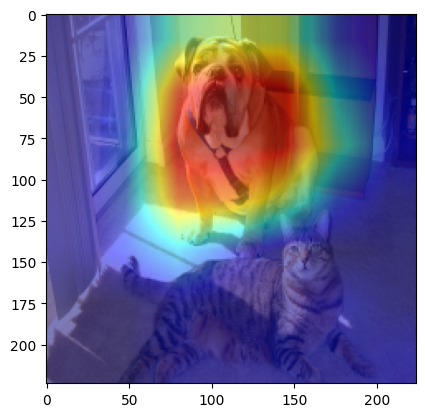

In [19]:
plt.imshow(vis_both_GradCam)

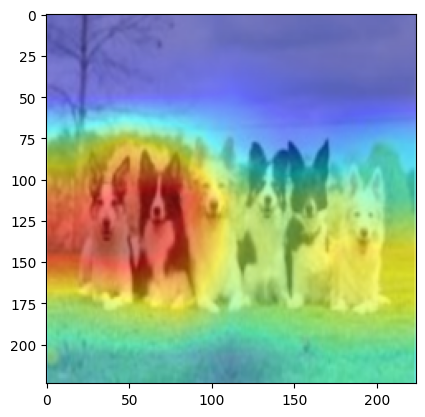

In [20]:
plt.imshow(vis_dog_GradCam)

##Grad_CAM++

In [21]:
%%time
image_path = 'both.png'
alg = 'gradcam++'
vis_both_gradcamPP = cam_vis(image_path , alg)

image_path = 'dogs.png'
vis_dog_gradcamPP = cam_vis(image_path , alg)

CPU times: user 83.2 ms, sys: 0 ns, total: 83.2 ms
Wall time: 85.6 ms


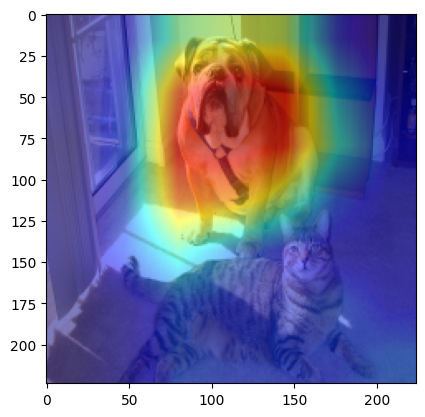

In [22]:
plt.imshow(vis_both_gradcamPP)

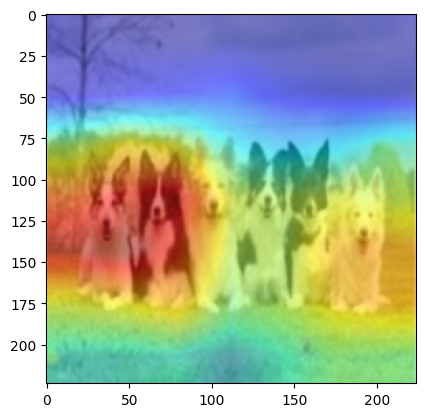

In [23]:
plt.imshow(vis_dog_gradcamPP)

##EigenCAM

In [27]:
%%time
image_path = 'both.png'
alg = 'eigencam'
vis_both_eigencam = cam_vis(image_path , alg)

image_path = 'dogs.png'
vis_dog_eigencam = cam_vis(image_path , alg)

CPU times: user 852 ms, sys: 291 ms, total: 1.14 s
Wall time: 605 ms


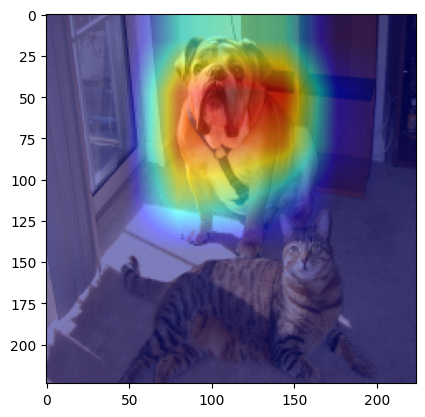

In [25]:
plt.imshow(vis_both_eigencam)

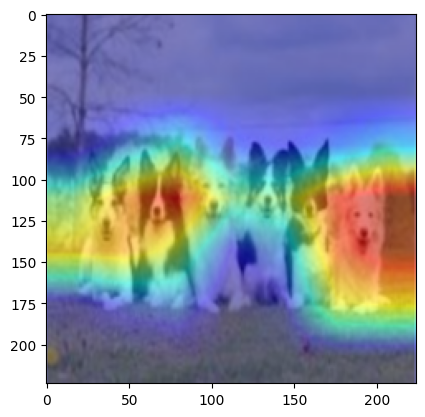

In [26]:
plt.imshow(vis_dog_eigencam)

##Score_CAM

In [28]:
%%time
image_path = 'both.png'
alg = 'scorecam'
vis_both_scorecam = cam_vis(image_path , alg)


image_path = 'dogs.png'
vis_dog_scorecam = cam_vis(image_path , alg)

100%|██████████| 128/128 [00:05<00:00, 21.42it/s]

CPU times: user 11.3 s, sys: 817 ms, total: 12.1 s
Wall time: 12.3 s


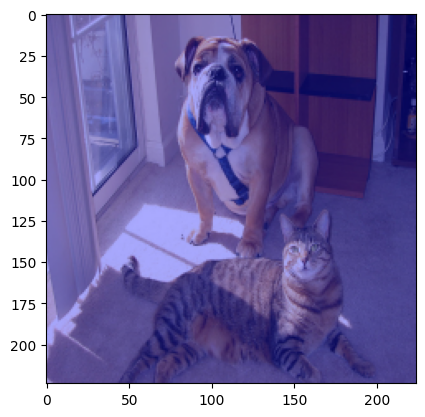

In [29]:
plt.imshow(vis_both_scorecam)

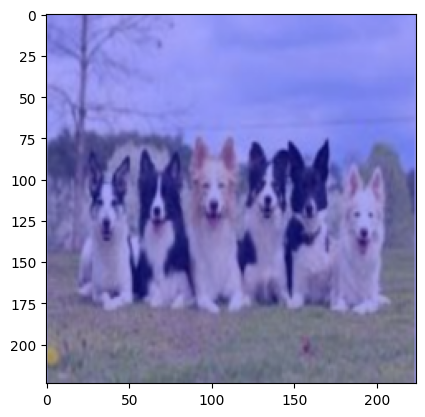

In [30]:
plt.imshow(vis_dog_scorecam)

##GradCAMElementWise

In [34]:
%%time
image_path = 'both.png'
alg = 'gradcamelemwise'
vis_both_gradcamelemwise = cam_vis(image_path , alg)


image_path = 'dogs.png'
vis_dog_gradcamelemwise = cam_vis(image_path , alg)

CPU times: user 96 ms, sys: 303 µs, total: 96.3 ms
Wall time: 109 ms


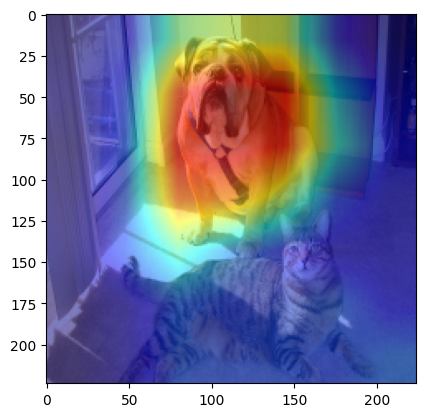

In [35]:
plt.imshow(vis_both_gradcamelemwise)

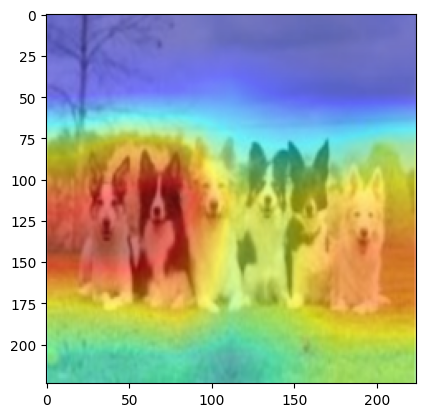

In [36]:
plt.imshow(vis_dog_gradcamelemwise)

##XGradCAM

In [37]:
%%time
image_path = 'both.png'
alg = 'xgradcam'
vis_both_xgradcam = cam_vis(image_path , alg)


image_path = 'dogs.png'
vis_dog_xgradcam = cam_vis(image_path , alg)

CPU times: user 78.9 ms, sys: 1.15 ms, total: 80.1 ms
Wall time: 84.3 ms


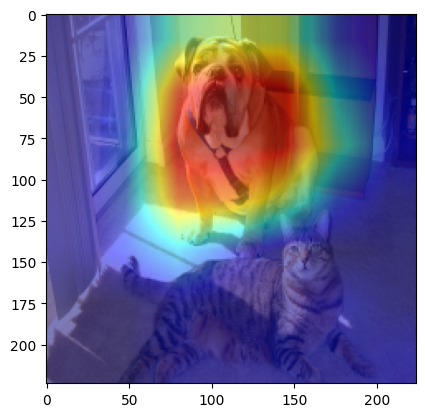

In [38]:
plt.imshow(vis_both_xgradcam)

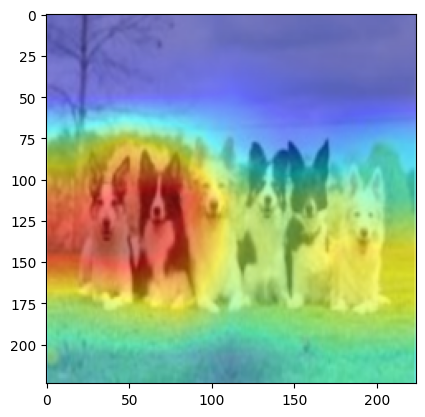

In [39]:
plt.imshow(vis_dog_xgradcam)

##TIME for each method
the time it takes for different approaches varies acorrding to different factors, in general , scoreCAM consumes the most time and other methods time are close together, but if we sort these methods based on the time each methods has consumed in our run we would have :  Grad-CAM < XGrad-CAM < Grad-CAM ElementWise < Grad-CAM++ < Eign-CAM < Score-CAM

## method for comparison
GradCAM: GradCAM (Gradient-weighted Class Activation Mapping) is a widely used method that utilizes gradients to generate heatmaps highlighting the important regions of an input image. It provides pixel-level insights into the model's decision-making process and can be a good starting point for interpretability analysis.

GradCAMPlusPlus: GradCAMPlusPlus is an extension of GradCAM that aims to improve the localization accuracy of important regions. It incorporates higher-order derivatives to refine the heatmaps and provide more precise interpretations.

EigenCAM: EigenCAM uses the concept of eigenvalues to highlight salient regions in the input image. It captures the important dimensions of the feature maps to generate the interpretability heatmaps.

ScoreCAM: ScoreCAM assigns importance scores to each pixel based on the gradient and activation values. It provides fine-grained interpretability by highlighting regions that significantly contribute to the final prediction.

GradCAMElementWise: GradCAMElementWise computes the element-wise product of gradients and activation maps, offering a different perspective on the model's decision-making process.

XGradCAM: XGradCAM combines the advantages of GradCAM and ScoreCAM by incorporating both gradient and score information. It provides a comprehensive interpretation of the model's decision by considering multiple factors.

To determine the best method for your specific use case, consider the interpretability requirements, the complexity of your model, and the insights you aim to gain. It may be beneficial to experiment with different methods and compare their heatmaps to identify the one that provides the most meaningful and informative interpretations.
you can compare the heatmaps generated by different methods against ground truth annotations or reference interpretations to assess their accuracy and alignment with human expectations. Quantitative metrics like IoU (Intersection over Union) or F1-score can be used to measure the overlap between the heatmap and the ground truth regions.

Remember that interpretability is a subjective concept, and the evaluation should involve domain experts or users who can provide meaningful feedback based on their knowledge and understanding of the problem domain.